In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.layers import LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math
# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

import warnings
warnings.simplefilter(action='ignore')


Recall that data was preprocessed in order to perform univariate analysis, and it was also splitted into training, validation and testing samples. For now we will keep them the same way, i.e. 70% training, 15% testing and 15% validation.

In [78]:
# LIAM
# train_df = pd.read_csv('/content/drive/MyDrive/q2/ADM/p4/Data/train.csv')
# test_df = pd.read_csv('/content/drive/MyDrive/q2/ADM/p4/Data/test.csv')
# val_df = pd.read_csv('/content/drive/MyDrive/q2/ADM/p4/Data/validation.csv')

# # CLARA
train_df = pd.read_csv('/content/drive/MyDrive/SEMESTER 2/ADM/Project 4/Data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/SEMESTER 2/ADM/Project 4/Data/test.csv')
val_df = pd.read_csv('/content/drive/MyDrive/SEMESTER 2/ADM/Project 4/Data/validation.csv')

In [79]:
train_df = train_df.sort_values(by='date')
val_df = val_df.sort_values(by='date')
test_df = test_df.sort_values(by='date')

train_df['date'] = train_df['date'].apply(pd.to_datetime)
val_df['date'] = val_df['date'].apply(pd.to_datetime)
test_df['date'] = test_df['date'].apply(pd.to_datetime)

df = pd.concat([train_df, val_df, test_df])
df.reset_index(inplace=True)

In [80]:
train_df.head(5)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [81]:
numerical = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

### Autocorrelation Plots

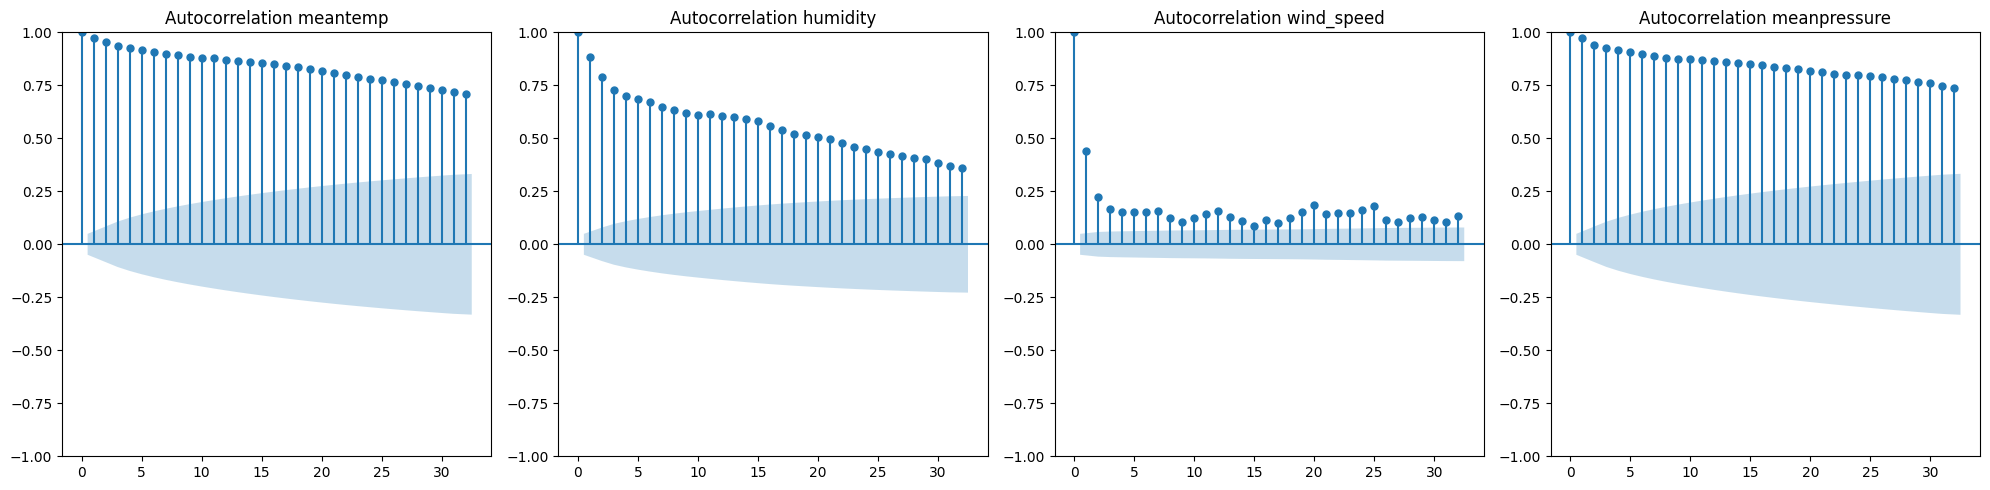

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
for i, column in enumerate(numerical):
    ax = axes[i]
    plot_acf(df[column], ax=ax)
    ax.set_title('Autocorrelation ' + column)
    
plt.tight_layout()
plt.show()

### Partial Autocorrelation Plots

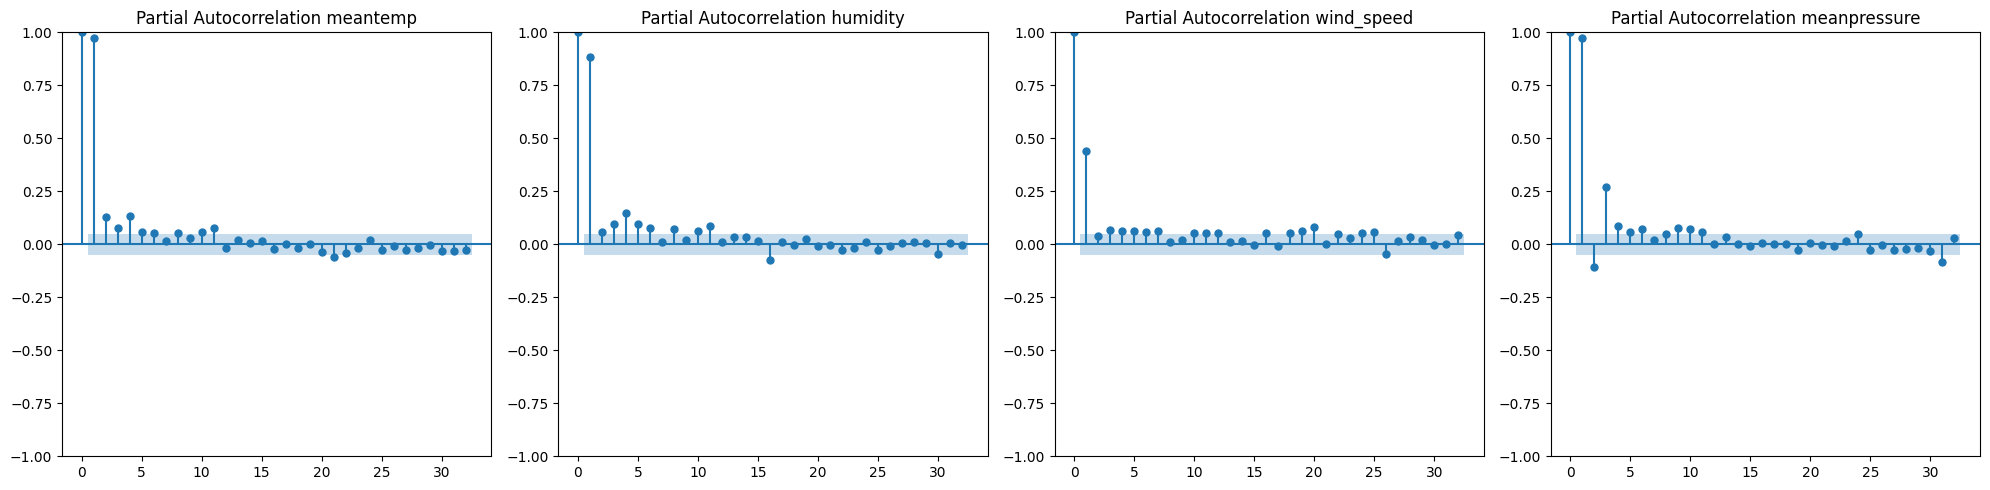

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
for i, column in enumerate(numerical):
    ax = axes[i]
    plot_pacf(df[column], ax=ax)
    ax.set_title('Partial Autocorrelation ' + column)
    
plt.tight_layout()
plt.show()

### Augmented Dickey-Fuller Test (ADF)

In [84]:
for i, column in enumerate(numerical):
    result = sm.tsa.stattools.adfuller(df[column])
    print('Attribute ', column, ':')
    print('   ADF Statistic:', result[0])
    print('   p-value:', result[1])
    print('   Critical Values:', result[4])
    if result[1] < 0.05:
        print('   Conclusion: The null hypothesis that attribute', column, 'is stationary is rejected.')
    else:
        print('   Conclusion: The null hypothesis fails to be rejected and attribute', column, 'is considered stationary.')
    print('\n')


Attribute  meantemp :
   ADF Statistic: -2.375315316581698
   p-value: 0.14882501564040673
   Critical Values: {'1%': -3.4345380212339838, '5%': -2.8633897592903237, '10%': -2.5677547800740443}
   Conclusion: The null hypothesis fails to be rejected and attribute meantemp is considered stationary.


Attribute  humidity :
   ADF Statistic: -3.6386181583150172
   p-value: 0.00506423100171985
   Critical Values: {'1%': -3.4345514752023365, '5%': -2.863395697445539, '10%': -2.567757942139848}
   Conclusion: The null hypothesis that attribute humidity is stationary is rejected.


Attribute  wind_speed :
   ADF Statistic: -4.006709476611348
   p-value: 0.001375783097999696
   Critical Values: {'1%': -3.4345759114452012, '5%': -2.8634064827605656, '10%': -2.5677636853277837}
   Conclusion: The null hypothesis that attribute wind_speed is stationary is rejected.


Attribute  meanpressure :
   ADF Statistic: -2.3263057234846043
   p-value: 0.16362414294789374
   Critical Values: {'1%': -3.43453

### Causality Test

In [85]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df_grangers_test = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df_grangers_test.columns:
        for r in df_grangers_test.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df_grangers_test.loc[r, c] = min_p_value
    df_grangers_test.columns = [var + '_x' for var in variables]
    df_grangers_test.index = [var + '_y' for var in variables]
    return df_grangers_test

grangers_causation_matrix(df[numerical], variables = numerical)

,meantemp_x,humidity_x,wind_speed_x,meanpressure_x
meantemp_y,1.0,0.0125,0.0000,0.0001
humidity_y,0.0,1.0000,0.1245,0.0068
wind_speed_y,0.0,0.0000,1.0000,0.0000
meanpressure_y,0.0,0.0003,0.0011,1.0000


### Cointegration Test

In [86]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def adjust(val, length= 6): return str(val).ljust(length)

def cointegration_test(df_cointegration, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df_cointegration,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    
    coint_vectors = out.evec
    # Create a DataFrame to display the cointegrating vectors
    coint_vectors_df = pd.DataFrame(coint_vectors, index=df_cointegration.columns, columns=[f'Coefficient {i+1}' for i in range(len(df_cointegration.columns))])


    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df_cointegration.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
    return coint_vectors_df

cointegration_test(df[numerical])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
meantemp ::  222.89    > 40.1749   =>   True
humidity ::  53.71     > 24.2761   =>   True
wind_speed ::  10.71     > 12.3212   =>   False
meanpressure ::  0.01      > 4.1296    =>   False


,Coefficient 1,Coefficient 2,Coefficient 3,Coefficient 4
meantemp,0.062524,-0.066235,0.142874,-0.031550
humidity,-0.014337,-0.083121,0.012495,-0.003002
wind_speed,-0.417544,-0.058499,0.022466,-0.000720
meanpressure,0.002142,0.007049,-0.004680,0.000003


### Adding Mean Temperature Day Before

In [87]:
def adding_meantemp_day_before(df, which_df=''):
  df['meantemp_day_before'] = 0

  for row in df.iterrows():
    if row[0] > 0:
      df.loc[row[0], 'meantemp_day_before'] = df.loc[row[0]-1, 'meantemp']
    elif which_df == 'val':
      last_prev_index = train_df.tail(1).index.item()
      df.loc[row[0], 'meantemp_day_before'] = train_df.loc[last_prev_index, 'meantemp']
    elif which_df == 'test':
      last_prev_index = val_df.tail(1).index.item()
      df.loc[row[0], 'meantemp_day_before'] = val_df.loc[last_prev_index, 'meantemp']
  return df.loc[1:] if which_df == 'train' else df

In [88]:
train_df = adding_meantemp_day_before(train_df, 'train')
val_df = adding_meantemp_day_before(val_df, 'val')
test_df = adding_meantemp_day_before(test_df, 'test')

In [89]:
train_df.tail(1).index.item()

1101

In [90]:
train_df

,date,meantemp,humidity,wind_speed,meanpressure,meantemp_day_before
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000,10.000000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667,7.400000
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667,7.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000,8.666667
5,2013-01-06,7.000000,82.800000,1.480000,1018.000000,6.000000
...,...,...,...,...,...,...
1097,2016-01-03,14.375000,74.750000,5.112500,1018.500000,14.000000
1098,2016-01-04,15.750000,77.125000,0.000000,1017.625000,14.375000
1099,2016-01-05,15.833333,88.833333,0.616667,1017.000000,15.750000
1100,2016-01-06,17.375000,81.625000,2.312500,1016.500000,15.833333


In [91]:
val_df

,date,meantemp,humidity,wind_speed,meanpressure,meantemp_day_before
0,2016-01-08,15.500000,83.250000,7.887500,1017.250000,17.125000
1,2016-01-09,15.857143,65.142857,8.471429,1015.428571,15.500000
2,2016-01-10,15.625000,74.375000,2.775000,1017.500000,15.857143
3,2016-01-11,15.750000,74.875000,1.625000,1017.500000,15.625000
4,2016-01-12,18.000000,69.687500,6.031250,1014.937500,15.750000
...,...,...,...,...,...,...
231,2016-08-26,31.222222,73.814815,4.392593,1005.222222,31.520000
232,2016-08-27,31.785714,70.285714,7.150000,1006.142857,31.222222
233,2016-08-28,33.400000,66.240000,7.272000,1006.200000,31.785714
234,2016-08-29,29.571429,82.321429,5.825000,1003.607143,33.400000


In [92]:
test_df

,date,meantemp,humidity,wind_speed,meanpressure,meantemp_day_before
0,2016-08-31,27.259259,89.555556,6.729630,1003.037037,30.040000
1,2016-09-01,27.960000,87.240000,4.148000,1002.440000,27.259259
2,2016-09-02,30.739130,71.739130,13.204348,1001.272727,27.960000
3,2016-09-03,30.894737,62.684211,13.263158,1001.157895,30.739130
4,2016-09-04,31.692308,59.307692,11.123077,1002.923077,30.894737
...,...,...,...,...,...,...
232,2017-04-20,34.500000,27.500000,5.562500,998.625000,33.500000
233,2017-04-21,34.250000,39.375000,6.962500,999.875000,34.500000
234,2017-04-22,32.900000,40.900000,8.890000,1001.600000,34.250000
235,2017-04-23,32.875000,27.500000,9.962500,1002.125000,32.900000


### Vector Autoregression (VAR)

### Data Differencing

In [93]:
train_df_diff = train_df[numerical].diff().dropna()

for i, column in enumerate(numerical):
    result = sm.tsa.stattools.adfuller(train_df_diff[column])
    print('Attribute ', column, ':')
    print('   ADF Statistic:', result[0])
    print('   p-value:', result[1])
    print('   Critical Values:', result[4])
    if result[1] < 0.05:
        print('   Conclusion: The null hypothesis fails to be rejected and attribute', column, 'is considered stationary.')
    else:
        print('   Conclusion: The null hypothesis that attribute', column, 'is stationary is rejected.')
    print('\n')


Attribute  meantemp :
   ADF Statistic: -12.485529700292405
   p-value: 3.0246527182877915e-23
   Critical Values: {'1%': -3.436369082756128, '5%': -2.8641976875421524, '10%': -2.5681850407995137}
   Conclusion: The null hypothesis fails to be rejected and attribute meantemp is considered stationary.


Attribute  humidity :
   ADF Statistic: -10.569645002375328
   p-value: 7.361792760331632e-19
   Critical Values: {'1%': -3.4364081161854747, '5%': -2.8642149051061954, '10%': -2.5681942108302214}
   Conclusion: The null hypothesis fails to be rejected and attribute humidity is considered stationary.


Attribute  wind_speed :
   ADF Statistic: -12.707309552348859
   p-value: 1.0483068488152921e-23
   Critical Values: {'1%': -3.436436308605049, '5%': -2.8642273405849363, '10%': -2.568200833956216}
   Conclusion: The null hypothesis fails to be rejected and attribute wind_speed is considered stationary.


Attribute  meanpressure :
   ADF Statistic: -14.078189471085723
   p-value: 2.8598152

All the variables are stationary with one level of differencing

Establishing Order(P)

In [94]:
model = VAR(train_df_diff[numerical])
minAIC = 10000000
minOrder = 1
for i in range(1, 20):
    result = model.fit(i)
    if result.aic < minAIC:
      minAIC = result.aic
      minOrder = i

print('MinOrder:', minOrder)
print('MinAIC:', minAIC)
    

MinOrder: 11
MinAIC: 8.274631356902365


The Order with minimum AIC is 11

### Model Fitted

In [95]:
model_fitted = model.fit(11)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 07, Jun, 2023
Time:                     13:19:34
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    9.09992
Nobs:                     1089.00    HQIC:                   8.58700
Log likelihood:          -10506.4    FPE:                    3923.82
AIC:                      8.27463    Det(Omega_mle):         3337.09
--------------------------------------------------------------------
Results for equation meantemp
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.003689         0.048309            0.076           0.939
L1.meantemp             -0.185228         0.042712           -4.337           0.000
L1.humidity              0.010795         0.0

### Checking for serial correlations in residuals

In [96]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df[numerical].columns, out):
    print(adjust(col), ':', round(val, 2))

meantemp : 2.0
humidity : 2.0
wind_speed : 2.01
meanpressure : 2.0


As the values are close to 2, there is no significant serial correlation

In [97]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = train_df_diff.values[-lag_order:]
forecast_input

11


array([[ 1.75      , -5.125     ,  3.        ,  0.25      ],
       [-0.75      ,  6.875     , -3.475     , -2.75      ],
       [-0.875     ,  6.75      , -5.3125    , -0.625     ],
       [-0.5       , -0.375     , -0.0125    ,  3.        ],
       [-0.28571429,  0.91071429, -1.03035714,  0.64285714],
       [-0.71428571,  3.58928571,  1.03035714, -0.14285714],
       [ 0.375     , -1.125     ,  3.025     , -2.5       ],
       [ 1.375     ,  2.375     , -5.1125    , -0.875     ],
       [ 0.08333333, 11.70833333,  0.61666667, -0.625     ],
       [ 1.54166667, -7.20833333,  1.69583333, -0.5       ],
       [-0.25      ,  5.375     , -2.3125    ,  1.625     ]])

### Forecast

In [98]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=len(val_df))
df_forecast = pd.DataFrame(fc, index=df.index[len(train_df):len(train_df)+len(val_df)], columns=df[numerical].columns + '_1d')
df_forecast

,meantemp_1d,humidity_1d,wind_speed_1d,meanpressure_1d
1101,0.030236,-4.672260,2.855015,0.210253
1102,-0.146061,-1.882441,1.002144,-0.772674
1103,-0.193813,0.131528,-0.629515,-0.316021
1104,-0.259140,-0.022951,-0.735631,0.030060
1105,0.195633,-1.985033,0.489198,0.389894
...,...,...,...,...
1332,0.002401,0.009473,-0.004476,0.002935
1333,0.002401,0.009473,-0.004476,0.002935
1334,0.002401,0.009473,-0.004476,0.002935
1335,0.002401,0.009473,-0.004476,0.002935


### Invert differencing

In [99]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[0] + (df_fc[str(col)+'_1d'].cumsum())
    return df_fc

In [100]:
df_results = invert_transformation(train_df[numerical], df_forecast, second_diff=False)        
df_results.reset_index(inplace=True)

### Plots

column name:  meantemp
Mean Squared Error: 497.70
Root Mean Squared Error: 22.31
column name:  humidity
Mean Squared Error: 1170.58
Root Mean Squared Error: 34.21
column name:  wind_speed
Mean Squared Error: 21.29
Root Mean Squared Error: 4.61
column name:  meanpressure
Mean Squared Error: 181.17
Root Mean Squared Error: 13.46


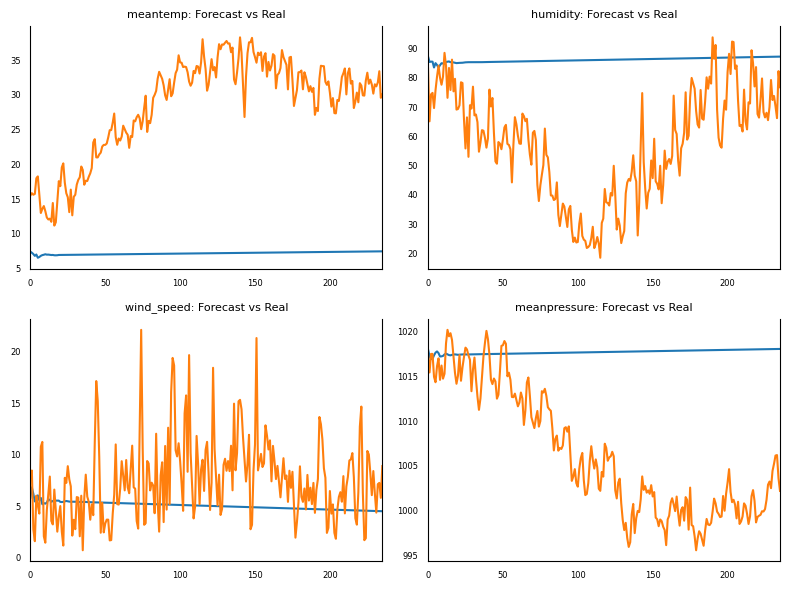

In [101]:
fig, axes = plt.subplots(nrows=int(len(numerical)/2), ncols=2, figsize=(8,6))
for i, (col,ax) in enumerate(zip(numerical, axes.flatten())):
    df_results[col+'_forecast'].plot(ax=ax).autoscale(axis='x',tight=True)
    val_df[col].plot(ax=ax)
    ax.set_title(col + ": Forecast vs Real", fontsize=8)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

    print('column name: ', col)
    mse = mean_squared_error(val_df[col], df_results[col+'_forecast'])
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")
    print('\n')

plt.tight_layout()

In [27]:
numerical

['meantemp', 'humidity', 'wind_speed', 'meanpressure']

## Adding Historical Data

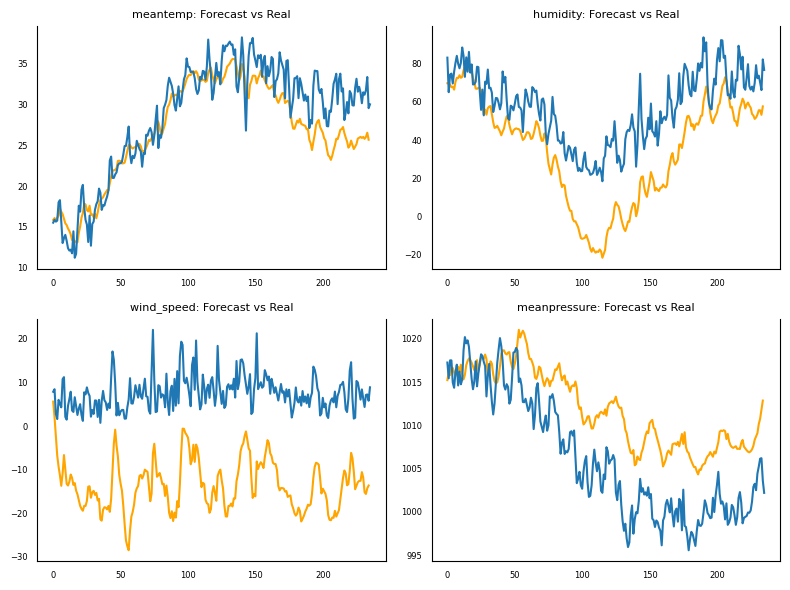

Attribute meantemp:
Mean Squared Error: 11.82
Root Mean Squared Error: 3.44


Attribute wind_speed:
Mean Squared Error: 484.21
Root Mean Squared Error: 22.00


Attribute humidity:
Mean Squared Error: 734.95
Root Mean Squared Error: 27.11


Attribute meanpressure:
Mean Squared Error: 45.63
Root Mean Squared Error: 6.75




In [105]:
# numerical_no_p = ['meantemp', 'humidity', 'wind_speed']
numerical_1d = [num + '_1d' for num in numerical]
def dailyVAR(lag_order=1):
  # prepare the data
  history = train_df_diff[numerical]
  predictions = pd.DataFrame(columns=numerical_1d)
  val = val_df[numerical].diff()

  # start the Walk-Forward process
  for t in range(1, len(val)):

      # create an VAR model with the historical data
      model = VAR(history)

      # train the model
      model_fitted = model.fit(lag_order)

      forecast_input = history.values[-lag_order:]
      forecasted_value = model_fitted.forecast(y=forecast_input, steps=1)

      # Multiplying to change the difference value's sign
      forecasted_value = pd.DataFrame(forecasted_value, columns=numerical_1d) * -1
      # add the predicted value to the list of predictions
      predictions = pd.concat([predictions, forecasted_value], ignore_index = True)

      # get the actual value for the current day
      actual_value = val.iloc[t]
      # add the actual value to the historical data for the next iteration
      history = pd.concat([history, actual_value.to_frame().T], ignore_index = True)

  predictions = invert_transformation(val_df.loc[1:, numerical], predictions)
  

  
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

  # Plot 1: meantemp
  axes[0, 0].plot(predictions['meantemp_forecast'], color='orange')
  axes[0, 0].plot(val_df['meantemp'])
  axes[0, 0].set_title('meantemp: Forecast vs Real', fontsize=8)

  # Plot 2: humidity
  axes[0, 1].plot(predictions['humidity_forecast'], color='orange')
  axes[0, 1].plot(val_df['humidity'])
  axes[0, 1].set_title('humidity: Forecast vs Real', fontsize=8)

  # Plot 3: wind_speed
  axes[1, 0].plot(predictions['wind_speed_forecast'], color='orange')
  axes[1, 0].plot(val_df['wind_speed'])
  axes[1, 0].set_title('wind_speed: Forecast vs Real', fontsize=8)

  # Plot 4: meanpressure
  axes[1, 1].plot(predictions['meanpressure_forecast'], color='orange')
  axes[1, 1].plot(val_df['meanpressure'])
  axes[1, 1].set_title('meanpressure: Forecast vs Real', fontsize=8)

  # Remove legends and adjust layout
  for ax in axes.flatten():
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
      ax.legend().remove()

  plt.tight_layout()
  plt.show()

  print('Attribute meantemp:')
  mse = mean_squared_error(val_df.loc[1:, 'meantemp'], predictions['meantemp_forecast'])
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")
  print('\n')

  print('Attribute wind_speed:')
  mse = mean_squared_error(val_df.loc[1:, 'wind_speed'], predictions['wind_speed_forecast'])
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")
  print('\n')

  print('Attribute humidity:')
  mse = mean_squared_error(val_df.loc[1:, 'humidity'], predictions['humidity_forecast'])
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")
  print('\n')

  print('Attribute meanpressure:')
  mse = mean_squared_error(val_df.loc[1:, 'meanpressure'], predictions['meanpressure_forecast'])
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")
  print('\n')

  return predictions, model_fitted

pred_temp, model_fitted = dailyVAR(lag_order = 11)

### Checking for serial correlations in residuals

In [106]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df[numerical].columns, out):
    print(adjust(col), ':', round(val, 2))

meantemp : 1.99
humidity : 2.0
wind_speed : 2.01
meanpressure : 2.0


### Adding Historical Data No Diff

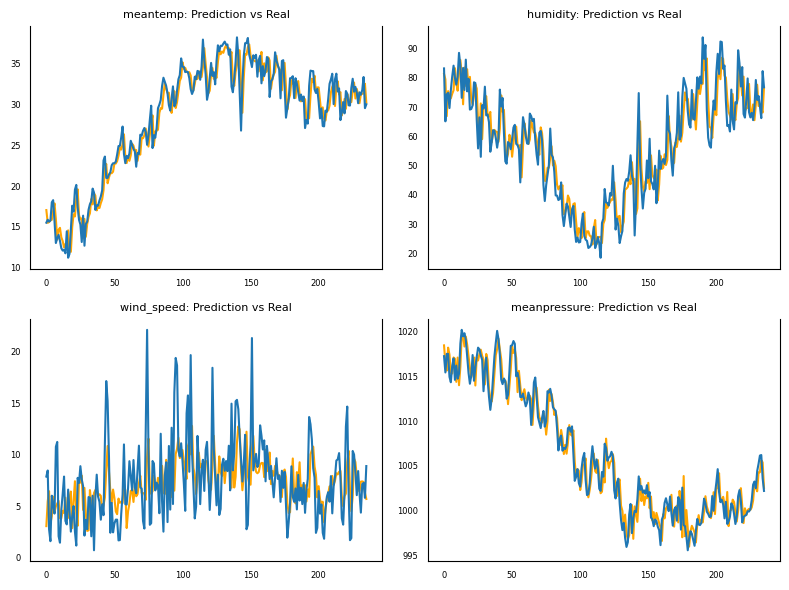

Attribute meantemp:
Mean Squared Error: 2.93
Root Mean Squared Error: 1.71


Attribute wind_speed:
Mean Squared Error: 11.14
Root Mean Squared Error: 3.34


Attribute humidity:
Mean Squared Error: 51.92
Root Mean Squared Error: 7.21


Attribute meanpressure:
Mean Squared Error: 2.33
Root Mean Squared Error: 1.53




In [107]:
# numerical_no_p = ['meantemp', 'humidity', 'wind_speed']
numerical_1d = [num + '_1d' for num in numerical]
def dailyVAR(lag_order=1):
  # prepare the data
  history = train_df[numerical]
  predictions = pd.DataFrame(columns=numerical)
  val = val_df[numerical]

  # start the Walk-Forward process
  for t in range(0, len(val)):

      # create an VAR model with the historical data
      model = VAR(history)

      # train the model
      model_fitted = model.fit(lag_order)

      forecast_input = history.values[-lag_order:]
      forecasted_value = model_fitted.forecast(y=forecast_input, steps=1)

      # Multiplying to change the difference value's sign
      forecasted_value = pd.DataFrame(forecasted_value, columns=numerical)
      # add the predicted value to the list of predictions
      predictions = pd.concat([predictions, forecasted_value], ignore_index = True)

      # get the actual value for the current day
      actual_value = val.iloc[t]
      # add the actual value to the historical data for the next iteration
      history = pd.concat([history, actual_value.to_frame().T], ignore_index = True)

  
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

  # Plot 4: meantemp
  axes[0, 0].plot(predictions['meantemp'], color='orange')
  axes[0, 0].plot(val_df['meantemp'])
  axes[0, 0].set_title('meantemp: Prediction vs Real', fontsize=8)

  # Plot 2: humidity
  axes[0, 1].plot(predictions['humidity'], color='orange')
  axes[0, 1].plot(val_df['humidity'])
  axes[0, 1].set_title('humidity: Prediction vs Real', fontsize=8)

  # Plot 3: wind_speed
  axes[1, 0].plot(predictions['wind_speed'], color='orange')
  axes[1, 0].plot(val_df['wind_speed'])
  axes[1, 0].set_title('wind_speed: Prediction vs Real', fontsize=8)

  # Plot 1: meanpressure
  axes[1, 1].plot(predictions['meanpressure'], color='orange')
  axes[1, 1].plot(val_df['meanpressure'])
  axes[1, 1].set_title('meanpressure: Prediction vs Real', fontsize=8)


  # Remove legends and adjust layout
  for ax in axes.flatten():
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
      ax.legend().remove()

  plt.tight_layout()
  plt.show()


  
  print('Attribute meantemp:')
  mse = mean_squared_error(val_df['meantemp'], predictions['meantemp'])
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")
  print('\n')

  print('Attribute wind_speed:')
  mse = mean_squared_error(val_df['wind_speed'], predictions['wind_speed'])
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")
  print('\n')

  print('Attribute humidity:')
  mse = mean_squared_error(val_df['humidity'], predictions['humidity'])
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")
  print('\n')

  print('Attribute meanpressure:')
  mse = mean_squared_error(val_df['meanpressure'], predictions['meanpressure'])
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")
  print('\n')

  return predictions, model_fitted

pred_temp, model_fitted = dailyVAR(lag_order = 11)

In [108]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df[numerical].columns, out):
    print(adjust(col), ':', round(val, 2))

meantemp : 2.0
humidity : 2.0
wind_speed : 2.01
meanpressure : 2.0


In [31]:
pd.concat([val_df['meantemp'], pred_temp], axis=1).head(50)

,meantemp,meantemp,humidity,wind_speed,meanpressure
0,15.500000,17.046951,81.408088,3.083884,1018.453635
1,15.857143,15.479219,79.525482,5.485639,1016.501054
2,15.625000,15.569357,66.908875,6.465619,1015.636659
3,15.750000,15.795510,75.498915,3.323056,1018.199752
4,18.000000,15.854294,73.915879,4.040912,1017.415434
5,18.266667,16.958136,73.012332,5.940060,1015.364431
6,15.562500,17.870883,74.546804,4.451096,1015.311491
7,13.000000,15.951307,75.776544,5.001012,1017.101977
8,13.600000,13.415050,83.324512,5.271784,1016.962373
9,14.000000,14.629045,78.126733,5.533930,1014.376747


In [32]:
model_fitted.params

,meantemp,humidity,wind_speed,meanpressure
const,0.761850,279.066801,139.171248,87.630225
L1.meantemp,0.804091,0.528054,-0.115958,-0.016320
L1.humidity,0.011563,0.852054,-0.093124,-0.002277
L1.wind_speed,-0.020351,0.034771,0.311947,-0.007566
L1.meanpressure,-0.036614,-0.112976,-0.010205,1.026443
L2.meantemp,-0.029636,-0.656992,0.479607,-0.060622
L2.humidity,-0.017351,-0.123878,0.097280,0.003090
L2.wind_speed,0.001199,0.010290,0.015097,0.006639
L2.meanpressure,0.005595,0.162701,0.003149,-0.389843
L3.meantemp,-0.012155,-0.060257,-0.095024,0.045531


In [33]:
val_df.loc[1:, numerical]

,meantemp,humidity,wind_speed,meanpressure
1,15.857143,65.142857,8.471429,1015.428571
2,15.625000,74.375000,2.775000,1017.500000
3,15.750000,74.875000,1.625000,1017.500000
4,18.000000,69.687500,6.031250,1014.937500
5,18.266667,75.800000,5.080000,1014.333333
...,...,...,...,...
231,31.222222,73.814815,4.392593,1005.222222
232,31.785714,70.285714,7.150000,1006.142857
233,33.400000,66.240000,7.272000,1006.200000
234,29.571429,82.321429,5.825000,1003.607143


### Support Vector Regression (SVR)

#### Without Temperature Day Before


In [34]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df.loc[:, ~train_df.columns.isin(['meantemp', 'meantemp_day_before', 'date'])])
X_val= scaler.fit_transform(val_df.loc[:, ~val_df.columns.isin(['meantemp', 'meantemp_day_before', 'date'])])
Y_train = train_df['meantemp']
Y_val = val_df['meantemp']

In [35]:
def applySVR(kernel, C, epsilon, best_param):
  svr_model = SVR(kernel = kernel, C = C, epsilon = epsilon)
  svr_model.fit(X_train, Y_train)
  y_pred = svr_model.predict(X_val)
  mse = mean_squared_error(Y_val, y_pred)
  
  if mse < best_param[3]:
      best_param[0] = kernel
      best_param[1] = C
      best_param[2] = epsilon
      best_param[3] = mse

  return best_param

In [36]:
from pandas.core.window.rolling import generate_manual_numpy_nan_agg_with_axis
import warnings
warnings.filterwarnings('ignore')

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
CS = [0.1, 1, 10]
epsilons = [0.1, 0.01, 0.001]
best_param = [100, 100, 100, 100]

for ker in kernels:
  for C in CS:
    for epsilon in epsilons:
        best_param = applySVR(ker, C, epsilon, best_param)

print(best_param)

['rbf', 0.1, 0.001, 13.88875425299457]


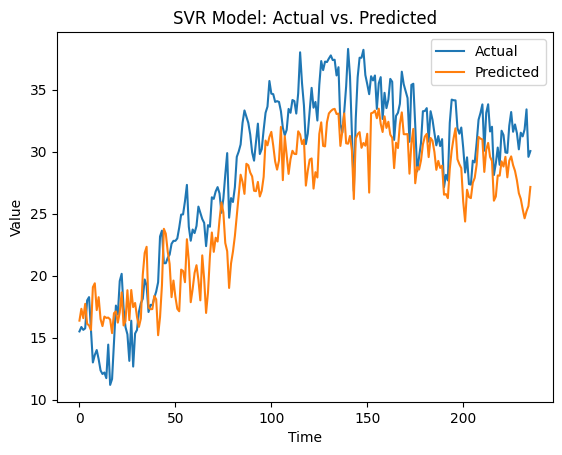

Mean Squared Error: 13.89
Root Mean Squared Error: 3.73


In [37]:
# Plotting actual values
svr_model = SVR(kernel = 'rbf', C = 0.1, epsilon =  0.001)
svr_model.fit(X_train, Y_train)
y_pred = svr_model.predict(X_val)

mse = mean_squared_error(Y_val, y_pred)

plt.plot(Y_val.index, Y_val, label='Actual')

# Plotting predicted values
plt.plot(Y_val.index, y_pred, label='Predicted')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('SVR Model: Actual vs. Predicted')
plt.legend()
plt.show()
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")

#### With Temperature Day Before

In [38]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df.loc[:, ~train_df.columns.isin(['meantemp', 'date'])])
X_val= scaler.fit_transform(val_df.loc[:, ~val_df.columns.isin(['meantemp', 'date'])])
Y_train = train_df['meantemp']
Y_val = val_df['meantemp']

In [39]:
from pandas.core.window.rolling import generate_manual_numpy_nan_agg_with_axis
import warnings
warnings.filterwarnings('ignore')

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
CS = [0.1, 1, 10]
epsilons = [0.1, 0.01, 0.001]
best_param = [100, 100, 100, 100]

for ker in kernels:
  for C in CS:
    for epsilon in epsilons:
        best_param = applySVR(ker, C, epsilon, best_param)

print(best_param)

['rbf', 1, 0.001, 11.779172715266391]


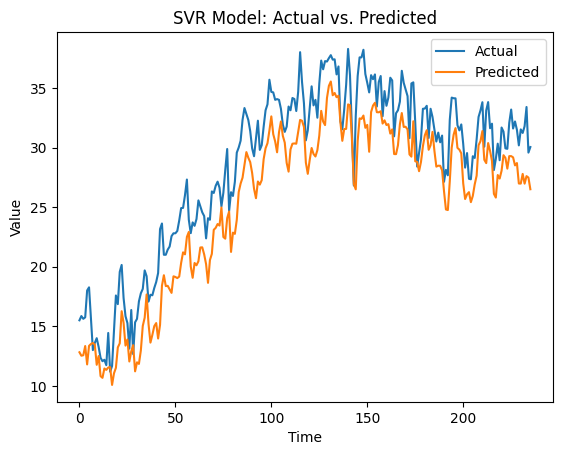

Mean Squared Error: 11.78
Root Mean Squared Error: 3.43


In [40]:
# Plotting actual values
svr_model = SVR(kernel = 'rbf', C = 1, epsilon =  0.001)
svr_model.fit(X_train, Y_train)
y_pred = svr_model.predict(X_val)

mse = mean_squared_error(Y_val, y_pred)

plt.plot(Y_val.index, Y_val, label='Actual')

# Plotting predicted values
plt.plot(Y_val.index, y_pred, label='Predicted')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('SVR Model: Actual vs. Predicted')
plt.legend()
plt.show()
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")

### With Multiple Lags

In [41]:
train_df['meantemp'].shift(7)

1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
         ...  
1097    15.375
1098    17.125
1099    16.375
1100    15.500
1101    15.000
Name: meantemp, Length: 1101, dtype: float64

In [42]:
def adding_meantemp_lags_before(df, days=7):
  for lag in range(1, days):
    df[f'meantemp_lag{lag}'] = df['meantemp'].shift(lag)
  return df



In [43]:
val_df

,date,meantemp,humidity,wind_speed,meanpressure,meantemp_day_before
0,2016-01-08,15.500000,83.250000,7.887500,1017.250000,17.125000
1,2016-01-09,15.857143,65.142857,8.471429,1015.428571,15.500000
2,2016-01-10,15.625000,74.375000,2.775000,1017.500000,15.857143
3,2016-01-11,15.750000,74.875000,1.625000,1017.500000,15.625000
4,2016-01-12,18.000000,69.687500,6.031250,1014.937500,15.750000
...,...,...,...,...,...,...
231,2016-08-26,31.222222,73.814815,4.392593,1005.222222,31.520000
232,2016-08-27,31.785714,70.285714,7.150000,1006.142857,31.222222
233,2016-08-28,33.400000,66.240000,7.272000,1006.200000,31.785714
234,2016-08-29,29.571429,82.321429,5.825000,1003.607143,33.400000


In [44]:
lags = 7
last_indexes = [train_df.tail(1).index.item() - lags + 2, train_df.tail(1).index.item() + val_df.tail(1).index.item()  - lags + 3]
temp_df = pd.concat([train_df, val_df, test_df], axis=0)
temp_df = temp_df.reset_index()

adding_meantemp_lags_before(temp_df, days=lags)
temp_df.dropna(inplace=True)
temp_df.drop(columns=['index'])
train_df = temp_df.iloc[:last_indexes[0]]
val_df = temp_df.iloc[last_indexes[0]:last_indexes[1]]
test_df = temp_df.iloc[last_indexes[1]:]

In [45]:
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df.loc[:, ~train_df.columns.isin(['meantemp', 'date'])])
X_val= scaler.fit_transform(val_df.loc[:, ~val_df.columns.isin(['meantemp', 'date'])])
Y_train = train_df['meantemp']
Y_val = val_df['meantemp']

In [46]:
from pandas.core.window.rolling import generate_manual_numpy_nan_agg_with_axis
import warnings
warnings.filterwarnings('ignore')

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
CS = [0.1, 1, 10]
epsilons = [0.1, 0.01, 0.001]
best_param = [100, 100, 100, 100]

for ker in kernels:
  for C in CS:
    for epsilon in epsilons:
        best_param = applySVR(ker, C, epsilon, best_param)

print(best_param)

['rbf', 1, 0.01, 11.309913169543233]


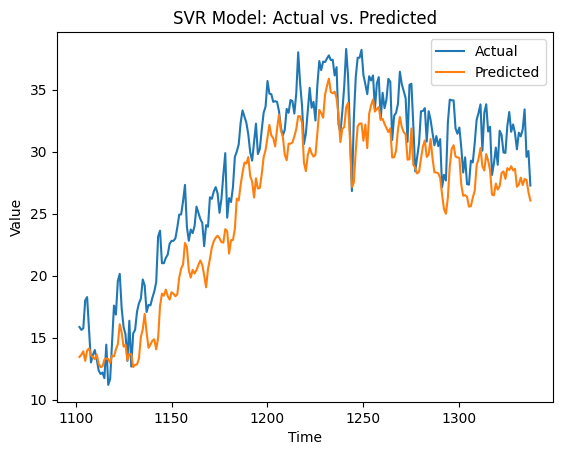

Mean Squared Error: 11.33
Root Mean Squared Error: 3.37


In [47]:
# Plotting actual values
svr_model = SVR(kernel = 'rbf', C = 1, epsilon =  0.1)
svr_model.fit(X_train, Y_train)
y_pred = svr_model.predict(X_val)

mse = mean_squared_error(Y_val, y_pred)

plt.plot(Y_val.index, Y_val, label='Actual')

# Plotting predicted values
plt.plot(Y_val.index, y_pred, label='Predicted')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('SVR Model: Actual vs. Predicted')
plt.legend()
plt.show()
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")

In [48]:
train_df

,index,date,meantemp,humidity,wind_speed,meanpressure,meantemp_day_before,meantemp_lag1,meantemp_lag2,meantemp_lag3,meantemp_lag4,meantemp_lag5,meantemp_lag6
6,7,2013-01-08,8.857143,63.714286,7.142857,1018.714286,7.000000,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000
7,8,2013-01-09,14.000000,51.250000,12.500000,1017.000000,8.857143,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667
8,9,2013-01-10,11.000000,62.000000,7.400000,1015.666667,14.000000,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667
9,10,2013-01-11,15.714286,51.285714,10.571429,1016.142857,11.000000,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000
10,11,2013-01-12,14.000000,74.000000,13.228571,1015.571429,15.714286,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,1098,2016-01-04,15.750000,77.125000,0.000000,1017.625000,14.375000,14.375000,14.000000,14.714286,15.000000,15.500000,16.375000
1098,1099,2016-01-05,15.833333,88.833333,0.616667,1017.000000,15.750000,15.750000,14.375000,14.000000,14.714286,15.000000,15.500000
1099,1100,2016-01-06,17.375000,81.625000,2.312500,1016.500000,15.833333,15.833333,15.750000,14.375000,14.000000,14.714286,15.000000
1100,1101,2016-01-07,17.125000,87.000000,0.000000,1018.125000,17.375000,17.375000,15.833333,15.750000,14.375000,14.000000,14.714286


### Support Vector Regression (SVR) making all attributes stationary

In [49]:
X_train = np.diff(X_train, axis=0)
Y_train = np.diff(Y_train, axis=0)
X_val = np.diff(X_val, axis=0)
Y_val2 = Y_val
Y_val = np.diff(Y_val, axis=0)

In [50]:
from pandas.core.window.rolling import generate_manual_numpy_nan_agg_with_axis
import warnings
warnings.filterwarnings('ignore')

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
CS = [0.1, 1, 10]
epsilons = [0.1, 0.01, 0.001]
best_param = [100, 100, 100, 100]

for ker in kernels:
  for C in CS:
    for epsilon in epsilons:
        best_param = applySVR(ker, C, epsilon, best_param)

print(best_param)

['linear', 10, 0.1, 1.5742234847338392]


In [51]:
def invert_transformation_series(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    df_fc['meantemp_forecast'] = df_train.iloc[0].values[0] + (df_fc['meantemp'].cumsum())
    return df_fc

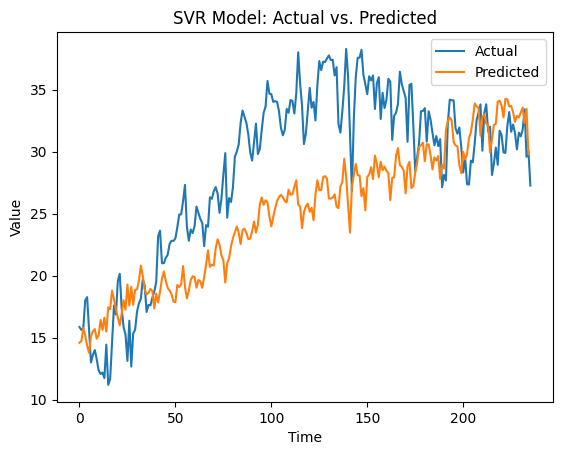

Mean Squared Error: 29.95
Root Mean Squared Error: 5.47


In [52]:
# Plotting actual values
svr_model = SVR(kernel = 'linear', C = 10, epsilon =  0.01)
svr_model.fit(X_train, Y_train)
y_pred = svr_model.predict(X_val)
y_pred = pd.DataFrame(y_pred, columns=['meantemp'])
y_pred = invert_transformation_series(pd.DataFrame(val_df['meantemp']), y_pred)

# It is from the first position because we apply differencing making
# pos 0 = NA
mse = mean_squared_error(Y_val2[1:], y_pred['meantemp_forecast'])

# Plotting actual values
plt.plot(range(len(Y_val2)), Y_val2, label='Actual')

# Plotting predicted values
plt.plot(range(len(y_pred)), y_pred['meantemp_forecast'], label='Predicted')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('SVR Model: Actual vs. Predicted')
plt.legend()
plt.show()
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")

### Gradient Boosting (GR)
#### Without Temperature Day Before

In [53]:
train_df.columns

Index(['index', 'date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure',
       'meantemp_day_before', 'meantemp_lag1', 'meantemp_lag2',
       'meantemp_lag3', 'meantemp_lag4', 'meantemp_lag5', 'meantemp_lag6'],
      dtype='object')

In [54]:
X_train = scaler.fit_transform(train_df.loc[:, ~train_df.columns.isin(['meantemp', 'meantemp_day_before', 'date', 'meantemp_lag1', 'meantemp_lag2',
       'meantemp_lag3', 'meantemp_lag4', 'meantemp_lag5', 'meantemp_lag6'])])
X_val= scaler.fit_transform(val_df.loc[:, ~val_df.columns.isin(['meantemp', 'meantemp_day_before', 'date', 'meantemp_lag1', 'meantemp_lag2',
       'meantemp_lag3', 'meantemp_lag4', 'meantemp_lag5', 'meantemp_lag6'])])
Y_train = train_df['meantemp']
Y_val = val_df['meantemp']

In [55]:
def applyGB(learning_rate, n_estimators, max_depth, best_param):
  gb_model = GradientBoostingRegressor(learning_rate = learning_rate, n_estimators = n_estimators, max_depth = max_depth)
  gb_model.fit(X_train, Y_train)
  y_pred = gb_model.predict(X_val)

  mse = mean_squared_error(Y_val, y_pred)
  
  if mse < best_param[3]:
      best_param[0] = learning_rate
      best_param[1] = n_estimators
      best_param[2] = max_depth
      best_param[3] = mse

  return best_param

##### Grid Search

In [56]:
from pandas.core.window.rolling import generate_manual_numpy_nan_agg_with_axis
import warnings
warnings.filterwarnings('ignore')

learning_rates = [0.1, 0.01, 0.001]
n_estimators = [100, 200, 300]
max_depths = [3, 5, 7]
best_param = [100, 100, 100, 100]

for rate in learning_rates:
  for num in n_estimators:
    for depth in max_depths:
        best_param = applyGB(rate, num, depth, best_param)

print(best_param)



[0.01, 300, 3, 15.664477918739333]


##### Plotting results of best model

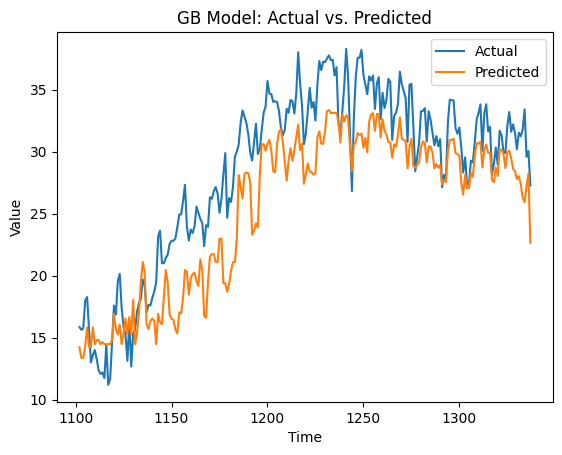

Mean Squared Error: 15.66
Root Mean Squared Error: 3.96


In [57]:
# Create an instance of the GradientBoostingRegressor
gb_model = GradientBoostingRegressor(learning_rate = 0.01, n_estimators = 300, max_depth = 3)

# Fit the gradient boosting model on the training data
gb_model.fit(X_train, Y_train)

# Make predictions for the future time steps using the test data
y_pred = gb_model.predict(X_val)

plt.plot(Y_val.index, Y_val, label='Actual')

# Plotting predicted values
plt.plot(Y_val.index, y_pred, label='Predicted')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('GB Model: Actual vs. Predicted')
plt.legend()
plt.show()

# Calculate the mean squared error
mse = mean_squared_error(Y_val, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")

#### With Temperature Day Before

In [58]:
X_train = scaler.fit_transform(train_df.loc[:, ~train_df.columns.isin(['meantemp', 'date', 'meantemp_lag1', 'meantemp_lag2',
       'meantemp_lag3', 'meantemp_lag4', 'meantemp_lag5', 'meantemp_lag6'])])
X_val= scaler.fit_transform(val_df.loc[:, ~val_df.columns.isin(['meantemp', 'date', 'meantemp_lag1', 'meantemp_lag2',
       'meantemp_lag3', 'meantemp_lag4', 'meantemp_lag5', 'meantemp_lag6'])])
Y_train = train_df['meantemp']
Y_val = val_df['meantemp']

##### Grid Search

In [59]:
from pandas.core.window.rolling import generate_manual_numpy_nan_agg_with_axis
import warnings
warnings.filterwarnings('ignore')

learning_rates = [0.1, 0.01, 0.001]
n_estimators = [100, 200, 300]
max_depths = [3, 5, 7]
best_param = [100, 100, 100, 100]

for rate in learning_rates:
  for num in n_estimators:
    for depth in max_depths:
        best_param = applyGB(rate, num, depth, best_param)

print(best_param)



[0.1, 200, 7, 11.753777722831563]


##### Plotting results of best model

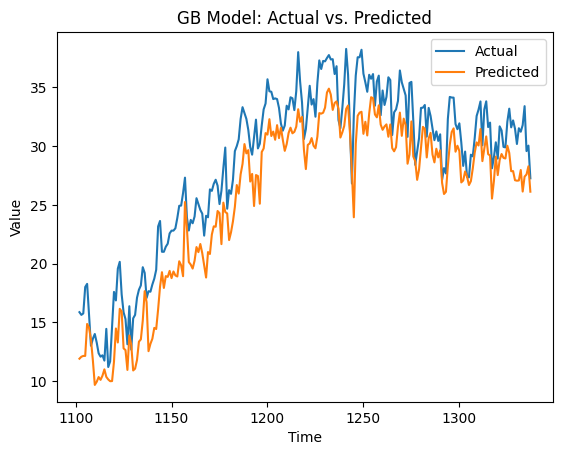

Mean Squared Error: 11.56
Root Mean Squared Error: 3.40


In [60]:
# Create an instance of the GradientBoostingRegressor
gb_model = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 100, max_depth = 7)

# Fit the gradient boosting model on the training data
gb_model.fit(X_train, Y_train)

# Make predictions for the future time steps using the test data
y_pred = gb_model.predict(X_val)

plt.plot(Y_val.index, Y_val, label='Actual')

# Plotting predicted values
plt.plot(Y_val.index, y_pred, label='Predicted')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('GB Model: Actual vs. Predicted')
plt.legend()
plt.show()

# Calculate the mean squared error
mse = mean_squared_error(Y_val, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")

#### With Multiple Lags

In [61]:
X_train = scaler.fit_transform(train_df.loc[:, ~train_df.columns.isin(['meantemp', 'date', 'meantemp_day_before'])])
X_val= scaler.fit_transform(val_df.loc[:, ~val_df.columns.isin(['meantemp', 'date', 'meantemp_day_before'])])
Y_train = train_df['meantemp']
Y_val = val_df['meantemp']

##### Grid Search

In [62]:
from pandas.core.window.rolling import generate_manual_numpy_nan_agg_with_axis
import warnings
warnings.filterwarnings('ignore')

learning_rates = [0.1, 0.01, 0.001]
n_estimators = [100, 200, 300]
max_depths = [3, 5, 7]
best_param = [100, 100, 100, 100]

for rate in learning_rates:
  for num in n_estimators:
    for depth in max_depths:
        best_param = applyGB(rate, num, depth, best_param)

print(best_param)



[0.01, 300, 5, 12.496427655938675]


##### Plotting results of best model

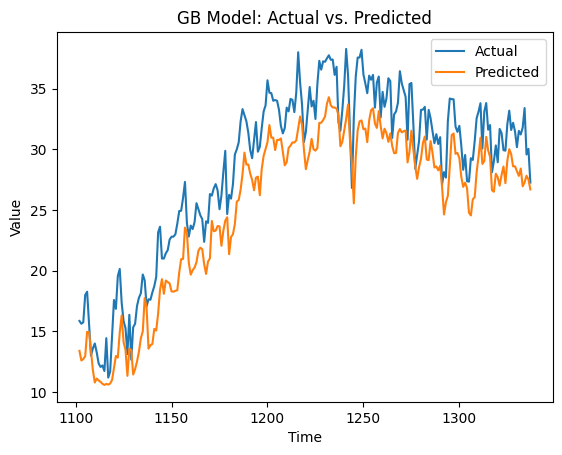

Mean Squared Error: 12.49
Root Mean Squared Error: 3.53


In [63]:
# Create an instance of the GradientBoostingRegressor
gb_model = GradientBoostingRegressor(learning_rate = 0.01, n_estimators = 300, max_depth = 5)

# Fit the gradient boosting model on the training data
gb_model.fit(X_train, Y_train)

# Make predictions for the future time steps using the test data
y_pred = gb_model.predict(X_val)

plt.plot(Y_val.index, Y_val, label='Actual')

# Plotting predicted values
plt.plot(Y_val.index, y_pred, label='Predicted')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('GB Model: Actual vs. Predicted')
plt.legend()
plt.show()

# Calculate the mean squared error
mse = mean_squared_error(Y_val, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")

### Gradient Boosting (GB) making all attributes stationary with one lag stationary

In [64]:
X_train = np.diff(X_train[:, 0:4], axis=0)
X_val = np.diff(X_val[:, 0:4], axis=0)
Y_train = np.diff(Y_train, axis=0)
Y_val2 = Y_val
Y_val = np.diff(Y_val, axis=0)

In [65]:
from pandas.core.window.rolling import generate_manual_numpy_nan_agg_with_axis
import warnings
warnings.filterwarnings('ignore')

learning_rates = [0.1, 0.01, 0.001]
n_estimators = [100, 200, 300]
max_depths = [3, 5, 7]
best_param = [100, 100, 100, 100]

for rate in learning_rates:
  for num in n_estimators:
    for depth in max_depths:
        best_param = applyGB(rate, num, depth, best_param)

print(best_param)

[0.1, 100, 3, 1.6279496494603858]


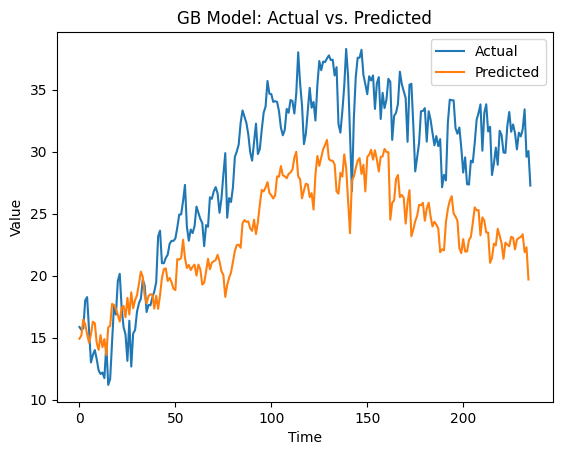

Mean Squared Error: 38.41
Root Mean Squared Error: 6.20


In [66]:
# Create an instance of the GradientBoostingRegressor
gb_model = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 200, max_depth = 3)
gb_model.fit(X_train, Y_train)
y_pred = gb_model.predict(X_val)

y_pred = pd.DataFrame(y_pred, columns=['meantemp'])
y_pred = invert_transformation_series(pd.DataFrame(val_df['meantemp']), y_pred)

# It is from the first position because we apply differencing making
# pos 0 = NA
mse = mean_squared_error(Y_val2[1:], y_pred['meantemp_forecast'])

# Plotting actual values
plt.plot(range(len(Y_val2)), Y_val2, label='Actual')

# Plotting predicted values
plt.plot(range(len(y_pred)), y_pred['meantemp_forecast'], label='Predicted')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('GB Model: Actual vs. Predicted')
plt.legend()
plt.show()
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")

### Long Short-Term Memory (LSTM)

In [67]:
train_df.head()

,index,date,meantemp,humidity,wind_speed,meanpressure,meantemp_day_before,meantemp_lag1,meantemp_lag2,meantemp_lag3,meantemp_lag4,meantemp_lag5,meantemp_lag6
6,7,2013-01-08,8.857143,63.714286,7.142857,1018.714286,7.000000,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000
7,8,2013-01-09,14.000000,51.250000,12.500000,1017.000000,8.857143,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667
8,9,2013-01-10,11.000000,62.000000,7.400000,1015.666667,14.000000,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667
9,10,2013-01-11,15.714286,51.285714,10.571429,1016.142857,11.000000,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000
10,11,2013-01-12,14.000000,74.000000,13.228571,1015.571429,15.714286,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000


In [68]:
X_train = scaler.fit_transform(train_df.loc[:, ~train_df.columns.isin(['meantemp', 'date', 'meantemp_day_before'])])
X_val= scaler.fit_transform(val_df.loc[:, ~val_df.columns.isin(['meantemp', 'date', 'meantemp_day_before'])])
Y_train = train_df['meantemp']
Y_val = val_df['meantemp']

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [69]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, X_train.shape[2]), return_sequences=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=45, batch_size=1, verbose=2)

Epoch 1/45
1096/1096 - 4s - loss: 615.1764 - 4s/epoch - 3ms/step
Epoch 2/45
1096/1096 - 4s - loss: 482.2191 - 4s/epoch - 3ms/step
Epoch 3/45
1096/1096 - 4s - loss: 298.3367 - 4s/epoch - 4ms/step
Epoch 4/45
1096/1096 - 3s - loss: 172.1516 - 3s/epoch - 3ms/step
Epoch 5/45
1096/1096 - 3s - loss: 101.6737 - 3s/epoch - 3ms/step
Epoch 6/45
1096/1096 - 3s - loss: 58.6593 - 3s/epoch - 3ms/step
Epoch 7/45
1096/1096 - 4s - loss: 33.5709 - 4s/epoch - 4ms/step
Epoch 8/45
1096/1096 - 2s - loss: 19.3869 - 2s/epoch - 2ms/step
Epoch 9/45
1096/1096 - 2s - loss: 11.6922 - 2s/epoch - 2ms/step
Epoch 10/45
1096/1096 - 2s - loss: 8.0751 - 2s/epoch - 1ms/step
Epoch 11/45
1096/1096 - 2s - loss: 6.5301 - 2s/epoch - 2ms/step
Epoch 12/45
1096/1096 - 2s - loss: 5.8254 - 2s/epoch - 2ms/step
Epoch 13/45
1096/1096 - 2s - loss: 5.3559 - 2s/epoch - 2ms/step
Epoch 14/45
1096/1096 - 2s - loss: 4.9175 - 2s/epoch - 2ms/step
Epoch 15/45
1096/1096 - 2s - loss: 4.4190 - 2s/epoch - 2ms/step
Epoch 16/45
1096/1096 - 2s - loss: 

In [70]:
# Estimate model performance
trainScore = model.evaluate(X_train, Y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
valScore = model.evaluate(X_val, Y_val, verbose=0)
print('Validation Score: %.2f MSE (%.2f RMSE)' % (valScore, math.sqrt(valScore)))


Train Score: 1.50 MSE (1.22 RMSE)
Validation Score: 12.25 MSE (3.50 RMSE)


8/8 [==============================] - 0s 3ms/step


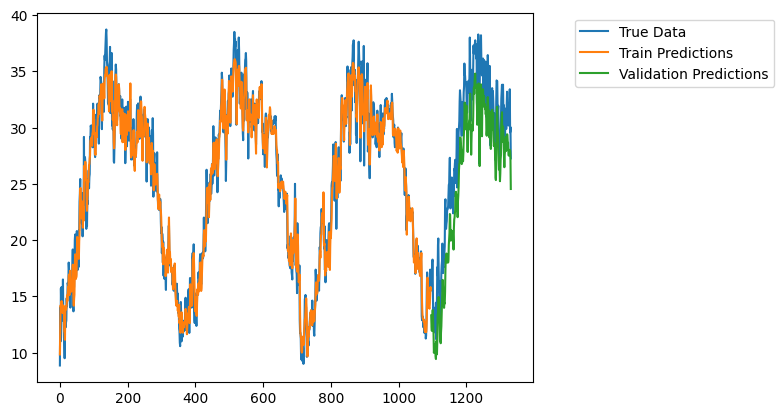

In [71]:
# generate predictions for training
trainPredict = model.predict(X_train).flatten()
valPredict = model.predict(X_val).flatten()


# # shift test predictions for plotting
valPredictPlot = np.empty_like(np.concatenate((trainPredict, valPredict), axis=0))
valPredictPlot[:] = np.nan
valPredictPlot[len(trainPredict):len(np.concatenate((trainPredict, valPredict), axis=0))] = valPredict


# plot baseline and predictions
temp1 = np.array( train_df['meantemp'])
temp2 = np.array( val_df['meantemp'])
df_temp = np.concatenate((temp1, temp2))

plt.plot(df_temp, label='True Data')
# plt.show()
plt.plot(trainPredict, label='Train Predictions')
plt.plot(valPredictPlot, label='Validation Predictions')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()

### LSTM with Sliding window

In [72]:
train_df

,index,date,meantemp,humidity,wind_speed,meanpressure,meantemp_day_before,meantemp_lag1,meantemp_lag2,meantemp_lag3,meantemp_lag4,meantemp_lag5,meantemp_lag6
6,7,2013-01-08,8.857143,63.714286,7.142857,1018.714286,7.000000,7.000000,7.000000,6.000000,8.666667,7.166667,7.400000
7,8,2013-01-09,14.000000,51.250000,12.500000,1017.000000,8.857143,8.857143,7.000000,7.000000,6.000000,8.666667,7.166667
8,9,2013-01-10,11.000000,62.000000,7.400000,1015.666667,14.000000,14.000000,8.857143,7.000000,7.000000,6.000000,8.666667
9,10,2013-01-11,15.714286,51.285714,10.571429,1016.142857,11.000000,11.000000,14.000000,8.857143,7.000000,7.000000,6.000000
10,11,2013-01-12,14.000000,74.000000,13.228571,1015.571429,15.714286,15.714286,11.000000,14.000000,8.857143,7.000000,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,1098,2016-01-04,15.750000,77.125000,0.000000,1017.625000,14.375000,14.375000,14.000000,14.714286,15.000000,15.500000,16.375000
1098,1099,2016-01-05,15.833333,88.833333,0.616667,1017.000000,15.750000,15.750000,14.375000,14.000000,14.714286,15.000000,15.500000
1099,1100,2016-01-06,17.375000,81.625000,2.312500,1016.500000,15.833333,15.833333,15.750000,14.375000,14.000000,14.714286,15.000000
1100,1101,2016-01-07,17.125000,87.000000,0.000000,1018.125000,17.375000,17.375000,15.833333,15.750000,14.375000,14.000000,14.714286


In [73]:
# Select the attributes for input features
input_features = [col for col in train_df.columns if col not in ['index', 'date', 'meantemp']]

# Select the target variable
target_variable = 'meantemp'

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_df[input_features + [target_variable]].values)

# Define the sliding window size
window_size = 10

# Create the input sequences and corresponding targets
train_X = []
train_y = []
for i in range(len(scaled_data) - window_size):
    train_X.append(scaled_data[i:i+window_size, :-1])
    train_y.append(scaled_data[i+window_size, -1])
train_X = np.array(train_X)
train_y = np.array(train_y)

scaled_data = scaler.fit_transform(val_df[input_features + [target_variable]].values)

# Create the input sequences and corresponding targets
val_X = []
val_y = []
for i in range(len(scaled_data) - window_size):
    val_X.append(scaled_data[i:i+window_size, :-1])
    val_y.append(scaled_data[i+window_size, -1])
val_X = np.array(val_X)
val_y = np.array(val_y)

### Train LSTM Model

In [74]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define a function to create the LSTM model
def create_model(units):
    model = Sequential()
    model.add(LSTM(units, input_shape=(window_size, len(input_features))))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Wrap the Keras model in a scikit-learn estimator
estimator = KerasRegressor(build_fn=create_model, verbose=1)

# Define the parameter grid for the grid search
param_grid = {
    'epochs': [50, 100, 150],
    'batch_size': [16, 32, 64],
    'units': [32, 64, 128]
}

# Perform the grid search
grid_search = GridSearchCV(estimator, param_grid=param_grid, cv=3)
grid_result = grid_search.fit(train_X, train_y)

# Print the best parameters and scores
print("Best parameters: ", grid_result.best_params_)
print("Best score: ", grid_result.best_score_)

Epoch 1/50
46/46 [==============================] - 4s 7ms/step - loss: 0.0543
Epoch 2/50
46/46 [==============================] - 0s 7ms/step - loss: 0.0081
Epoch 3/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0073
Epoch 4/50
46/46 [==============================] - 0s 8ms/step - loss: 0.0068
Epoch 5/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 6/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0060
Epoch 7/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 8/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0056
Epoch 9/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0056
Epoch 10/50
46/46 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 11/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0053
Epoch 12/50
46/46 [==============================] - 0s 6ms/step - loss: 0.0051
Epoch 13/50
46/46 [==============================

KeyboardInterrupt: ignored

In [ ]:
model = create_model(32)
model.fit(train_X, train_y, epochs=150, batch_size=16)

# Prepare the test data
val_X = []
scaled_data = scaler.fit_transform(val_df[input_features + [target_variable]].values)

for i in range(len(val_df) - window_size + 1):
    val_X.append(scaled_data[i:i+window_size, :-1])
val_X = np.array(val_X)

# Make predictions on the test data
predicted_values = model.predict(val_X)

# Reshape the predicted values
predicted_values = np.reshape(predicted_values, (-1, 1))

# Inverse transform the predicted values
predicted_values = scaler.inverse_transform(np.concatenate((val_X.reshape(-1, window_size, len(input_features))[:, -1], predicted_values), axis=1))
predicted_meantemp = predicted_values[:, -1]

# Add the predicted 'meantemp' values to the test dataframe
val_df['predicted_meantemp'] = np.pad(predicted_meantemp, (9, 0), 'constant')

In [ ]:
# val_df.reset_index(inplace=True)

plt.plot(val_df.loc[window_size - 1 :,].index, val_df.loc[window_size - 1:, 'meantemp'], label='Actual')

# Plotting predicted values
plt.plot(val_df.loc[window_size - 1 :,].index, val_df.loc[window_size - 1:, 'predicted_meantemp'], label='Predicted')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('LSTM Model: Actual vs. Predicted')
plt.legend()
plt.show()

# Calculate the mean squared error
mse = mean_squared_error(val_df.loc[window_size-1:, 'meantemp'], val_df.loc[window_size-1:, 'predicted_meantemp'])

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print()
print("MSE:", mse)
print("RMSE:", rmse)

### Testing (VAR model with history and without differencing)

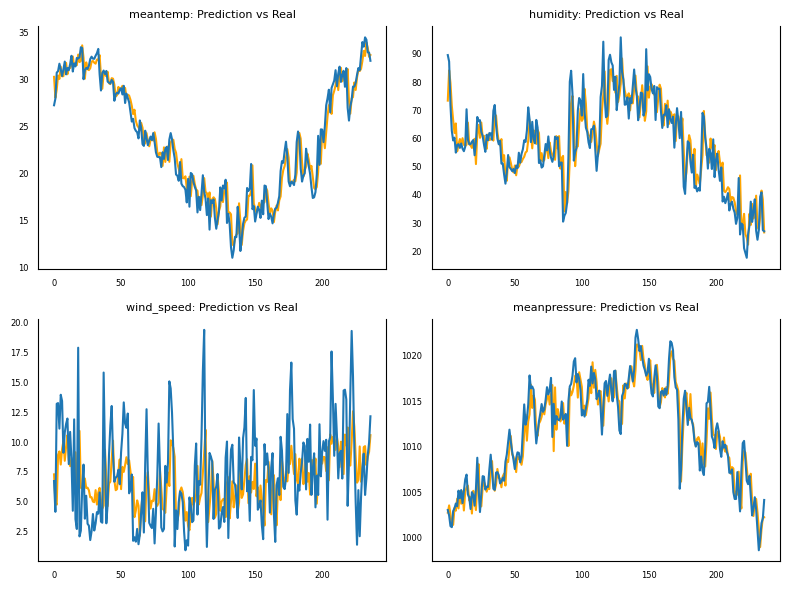

Attribute meantemp:
Mean Squared Error: 2.14
Root Mean Squared Error: 1.46


Attribute wind_speed:
Mean Squared Error: 12.69
Root Mean Squared Error: 3.56


Attribute humidity:
Mean Squared Error: 47.87
Root Mean Squared Error: 6.92


Attribute meanpressure:
Mean Squared Error: 3.01
Root Mean Squared Error: 1.73




In [111]:
def dailyVAR(lag_order=1):
  # prepare the data
  history = pd.concat([train_df[numerical], val_df[numerical]])
  predictions = pd.DataFrame(columns=numerical)
  val = test_df[numerical]

  # start the Walk-Forward process
  for t in range(0, len(val)):

      # create an VAR model with the historical data
      model = VAR(history)

      # train the model
      model_fitted = model.fit(lag_order)

      forecast_input = history.values[-lag_order:]
      forecasted_value = model_fitted.forecast(y=forecast_input, steps=1)

      # Multiplying to change the difference value's sign
      forecasted_value = pd.DataFrame(forecasted_value, columns=numerical)
      # add the predicted value to the list of predictions
      predictions = pd.concat([predictions, forecasted_value], ignore_index = True)

      # get the actual value for the current day
      actual_value = val.iloc[t]
      # add the actual value to the historical data for the next iteration
      history = pd.concat([history, actual_value.to_frame().T], ignore_index = True)

  
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

  # Plot 4: meantemp
  axes[0, 0].plot(predictions['meantemp'], color='orange')
  axes[0, 0].plot(test_df['meantemp'])
  axes[0, 0].set_title('meantemp: Prediction vs Real', fontsize=8)

  # Plot 2: humidity
  axes[0, 1].plot(predictions['humidity'], color='orange')
  axes[0, 1].plot(test_df['humidity'])
  axes[0, 1].set_title('humidity: Prediction vs Real', fontsize=8)

  # Plot 3: wind_speed
  axes[1, 0].plot(predictions['wind_speed'], color='orange')
  axes[1, 0].plot(test_df['wind_speed'])
  axes[1, 0].set_title('wind_speed: Prediction vs Real', fontsize=8)

  # Plot 1: meanpressure
  axes[1, 1].plot(predictions['meanpressure'], color='orange')
  axes[1, 1].plot(test_df['meanpressure'])
  axes[1, 1].set_title('meanpressure: Prediction vs Real', fontsize=8)


  # Remove legends and adjust layout
  for ax in axes.flatten():
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
      ax.legend().remove()

  plt.tight_layout()
  plt.show()


  
  print('Attribute meantemp:')
  mse = mean_squared_error(test_df['meantemp'], predictions['meantemp'])
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")
  print('\n')

  print('Attribute wind_speed:')
  mse = mean_squared_error(test_df['wind_speed'], predictions['wind_speed'])
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")
  print('\n')

  print('Attribute humidity:')
  mse = mean_squared_error(test_df['humidity'], predictions['humidity'])
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")
  print('\n')

  print('Attribute meanpressure:')
  mse = mean_squared_error(test_df['meanpressure'], predictions['meanpressure'])
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"Root Mean Squared Error: {np.sqrt(mse):.2f}")
  print('\n')

  return predictions, model_fitted

pred_temp, model_fitted = dailyVAR(lag_order = 11)